In [1]:
import os
import random
import pickle
import matplotlib.pyplot as plt

from termcolor import cprint 

from pycolonies import Colonies
from pycolonies import colonies_client
from pycolonies import func_spec

colonies, colonyid, colony_prvkey, executorid, executor_prvkey = colonies_client()

In [3]:
!colonies fs sync -l src -d /root/cfs/src --yes

INFO[0000] Synchronizing, nothing to do, already synchronized  Label=src SyncDir=/root/cfs/src/


In [42]:
src_snapshotname = str(random.randint(0,9**60))
src_snapshot = colonies.create_snapshot(colonyid, "/src", src_snapshotname, executor_prvkey)

data_snapshotname = str(random.randint(0,9**60))
data_snapshot = colonies.create_snapshot(colonyid, "/data", data_snapshotname, executor_prvkey)

def train_nn(ll):
   return {
      "conditions": {
          "colonyid": colonyid,
          "executortype": "borg-hpcexecutor",
          "nodes": 1,
          "processes_per_node": 1,
          "walltime": 600,
          "gpu": {
              "count": 1
          }
      },
      "funcname": "execute",
      "kwargs": {
          "cmd": "python3",
          "docker-image": "johan/classifier",
          "rebuild-image": False,
          "args": [
              "/cfs/src/{processid}/classifier.py"
          ],
          "learning-rate": ll
      },
      "fs": {
          "mount": "/cfs",
          "snapshots": [
              {
                  "snapshotid": src_snapshot["snapshotid"],
                  "label": "/src",
                  "dir": "/src/{processid}",
                  "keepfiles": False,
                  "keepsnaphot": False
              },
              {
                  "snapshotid": data_snapshot["snapshotid"],
                  "label": "/data",
                  "dir": "/data",
                  "keepfiles": True,
                  "keepsnaphot": False
              }
          ],
          "dirs": [
              {
                  "label": "/results",
                  "dir": "/results",
                  "keepfiles": True,
                  "onconflicts": {
                      "onstart": {
                          "keeplocal": False
                      },
                      "onclose": {
                          "keeplocal": True
                      }
                  }
              }
          ]
      },
      "maxwaittime": -1,
      "maxexectime": 600,
      "maxretries": 3
  }

f = train_nn(ll=0.001)
process = colonies.submit(f, executor_prvkey)

In [29]:
#for l in colonies.get_process_log(process["processid"], 500, -1, executor_prvkey):
#    cprint(l["message"], end="")

In [43]:
!colonies fs sync -l /results -d /root/cfs/results --yes --keeplocal=false

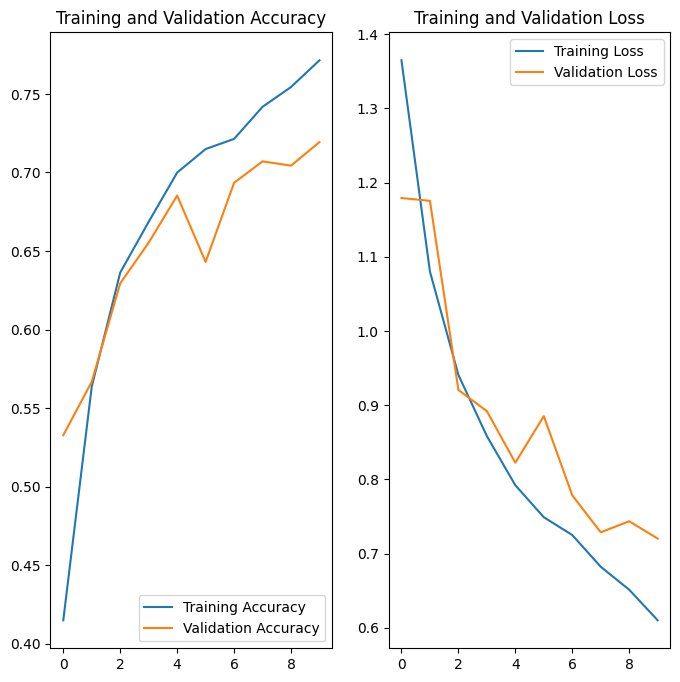

In [44]:
history = pickle.load(open( "/root/cfs/results/history.pickle", "rb"))
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()